In [2]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline

import logging

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load data from the specified path
df = pd.read_feather("../Data/Data1.feather")

python(20101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
X = df[['text', 'base_url', 'company_names']]
Y = df['sentiment']

In [4]:
# label encodinhg ytrain for xgboost
le =LabelEncoder()
y = le.fit_transform(Y)
y

array([1, 1, 0, ..., 1, 1, 1])

In [5]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

## **TF-IDF Vectoriser**

In [19]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_company = tfidf_vectorizer_url.fit_transform(X_train['company_names'])
X_test_tfidf_company = tfidf_vectorizer_url.transform(X_test['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url, X_train_tfidf_company])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url, X_test_tfidf_company])


In [20]:
xg_tf = XGBClassifier(n_estimators=10000,learning_rate = 0.3, max_depth = 5, n_jobs=-1)

In [21]:
xg_tf.fit(X_train_tfidf_combined, y_train)
# Predicting on the test set
y_pred = xg_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9340042124970747
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       389
           1       0.95      0.96      0.95      2584
           2       0.94      0.93      0.93      1300

    accuracy                           0.93      4273
   macro avg       0.91      0.89      0.90      4273
weighted avg       0.93      0.93      0.93      4273



In [22]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 311,   59,   19],
       [  44, 2476,   64],
       [  16,   80, 1204]])

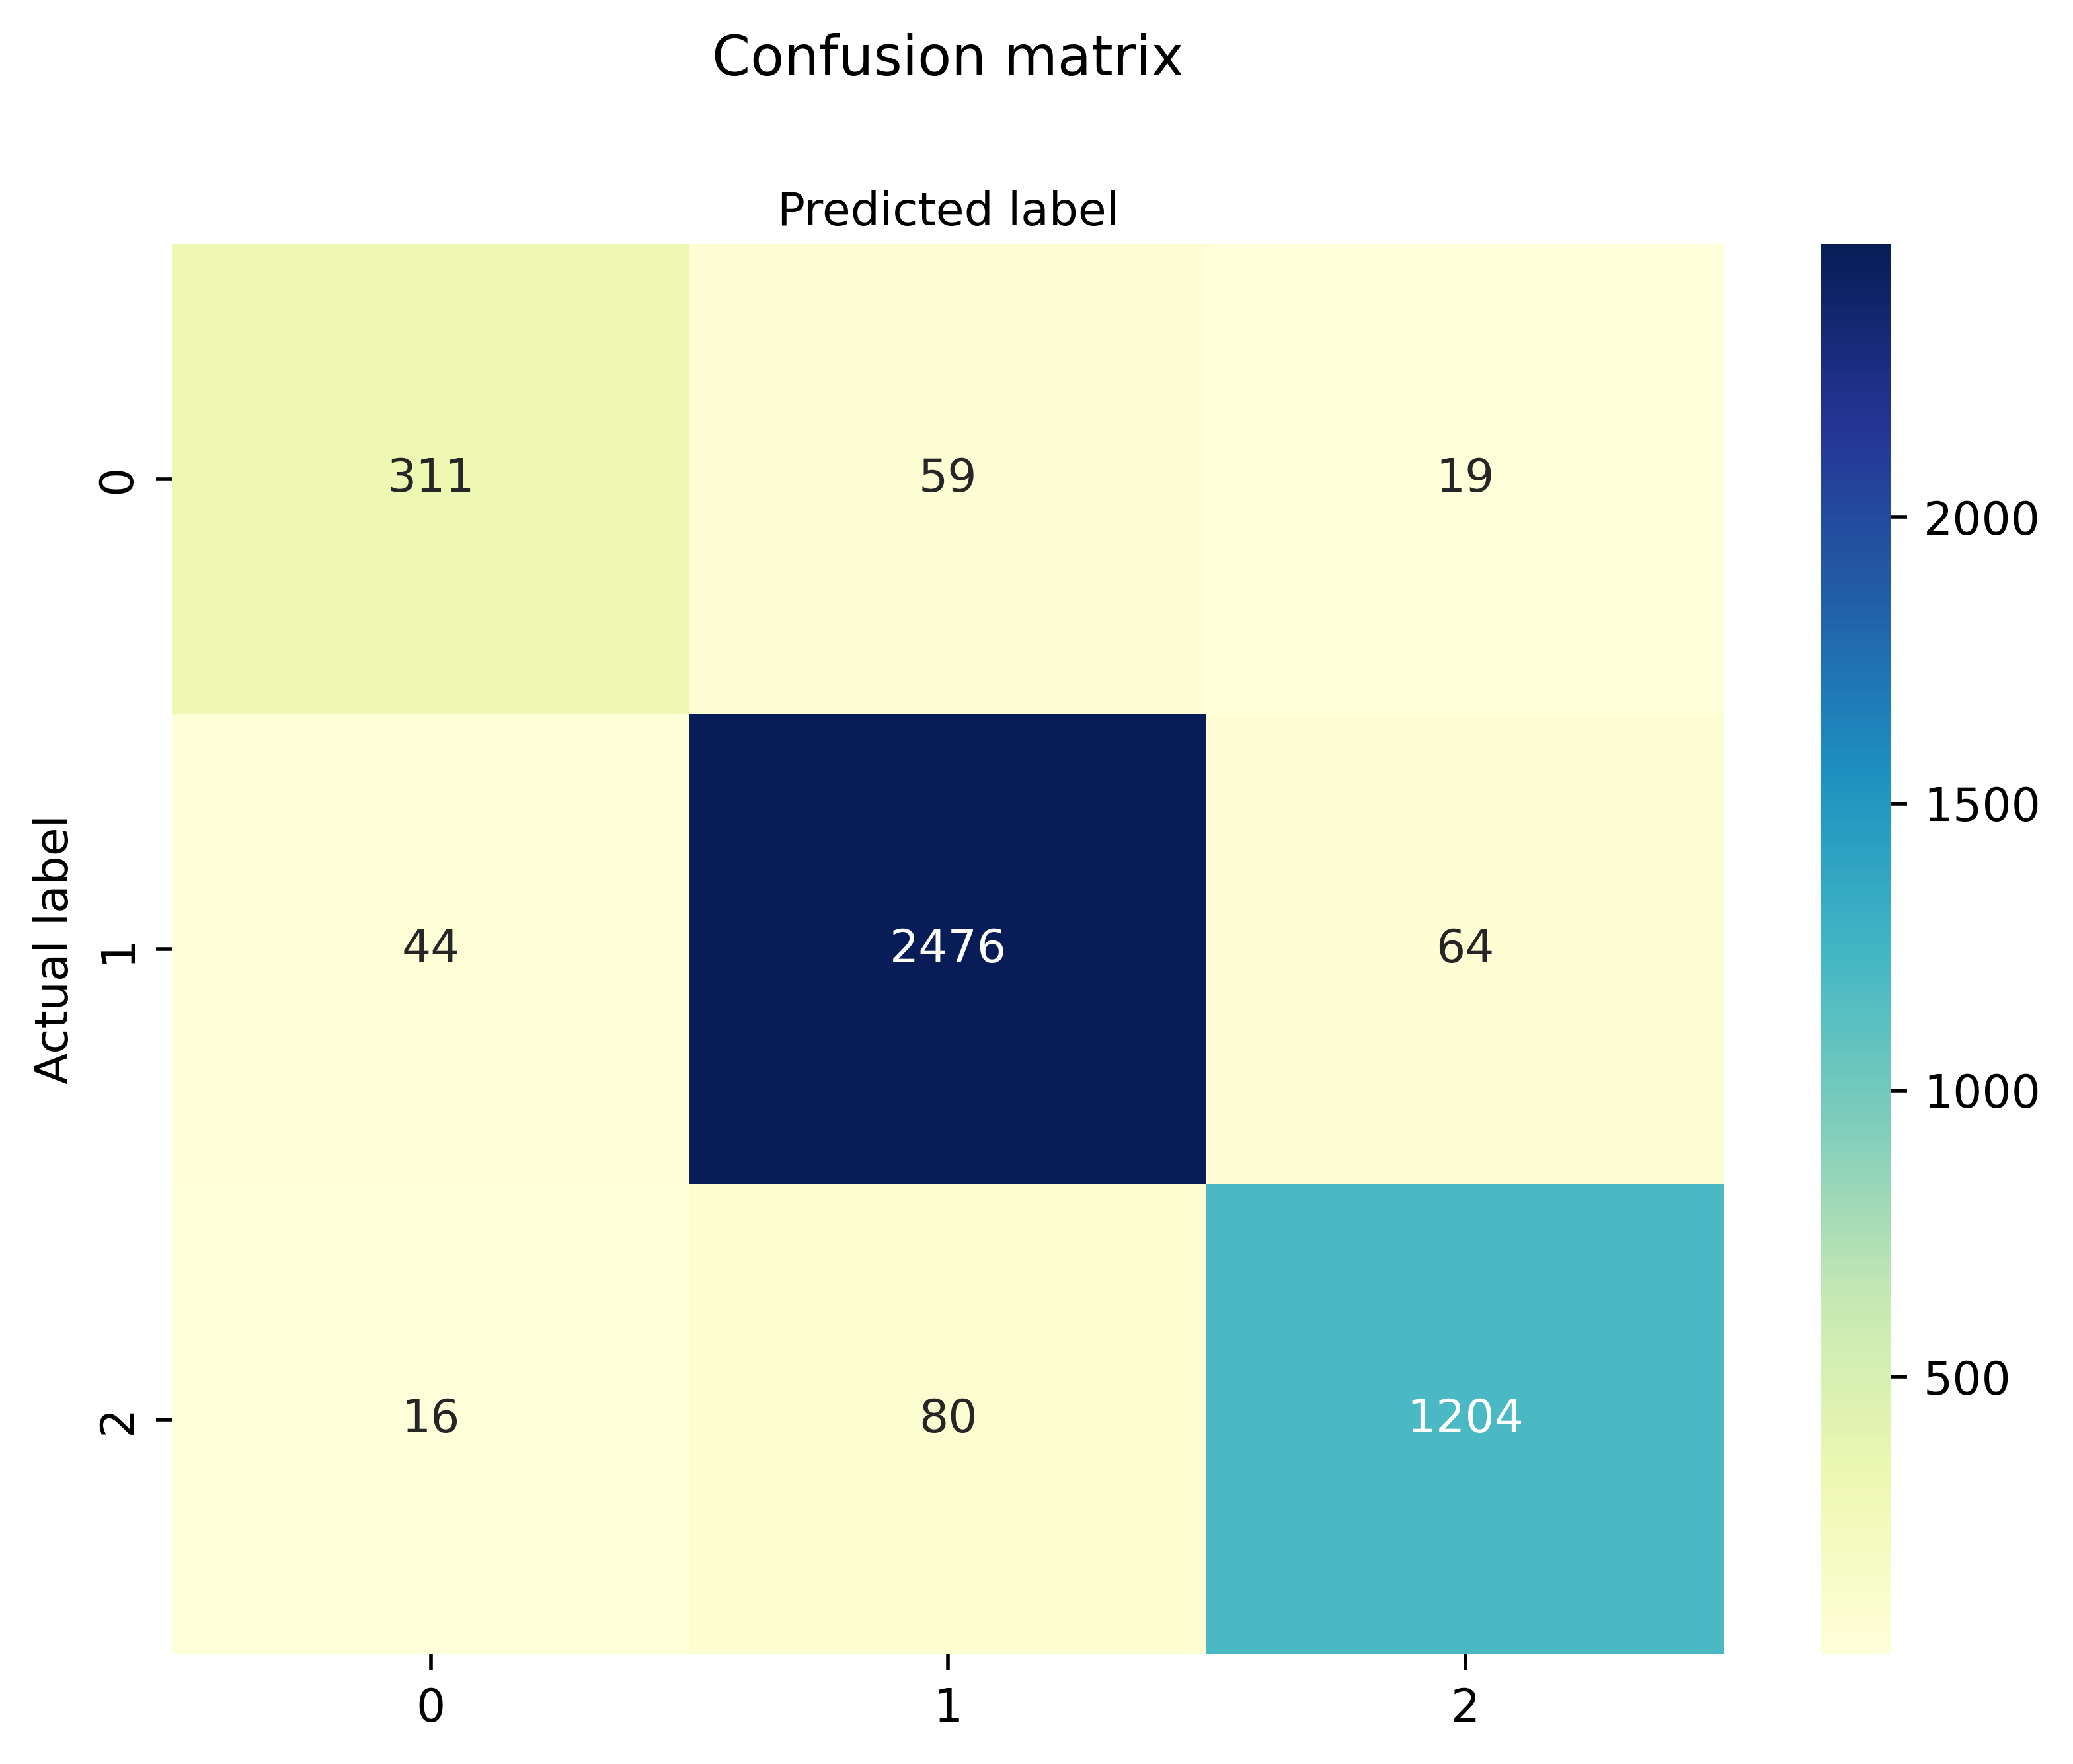

In [23]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

## **Bag-of-Words Vectoriser**

In [24]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)

# Fitting and transforming the text training set
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])
bow_vectorizer_url = CountVectorizer(max_features=1000)

# Fitting and transforming the url training set
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])
X_train_bow_company_name = bow_vectorizer_url.fit_transform(X_train['company_names'])
X_test_bow_company_name = bow_vectorizer_url.transform(X_test['company_names'])
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url, X_train_bow_company_name])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url, X_test_bow_company_name])


In [25]:
# Creating and training the vanilla random forest model for bow
xg_bow = XGBClassifier(n_estimators=10000,learning_rate = 0.3, max_depth = 5, n_jobs=-1)
xg_bow.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = xg_bow.predict(X_test_bow_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.940791013339574
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       389
           1       0.96      0.96      0.96      2584
           2       0.94      0.94      0.94      1300

    accuracy                           0.94      4273
   macro avg       0.91      0.91      0.91      4273
weighted avg       0.94      0.94      0.94      4273



In [26]:
# confusion matrix
cm_bow = confusion_matrix(y_test, y_pred)
cm_bow

array([[ 323,   50,   16],
       [  48, 2477,   59],
       [  14,   66, 1220]])

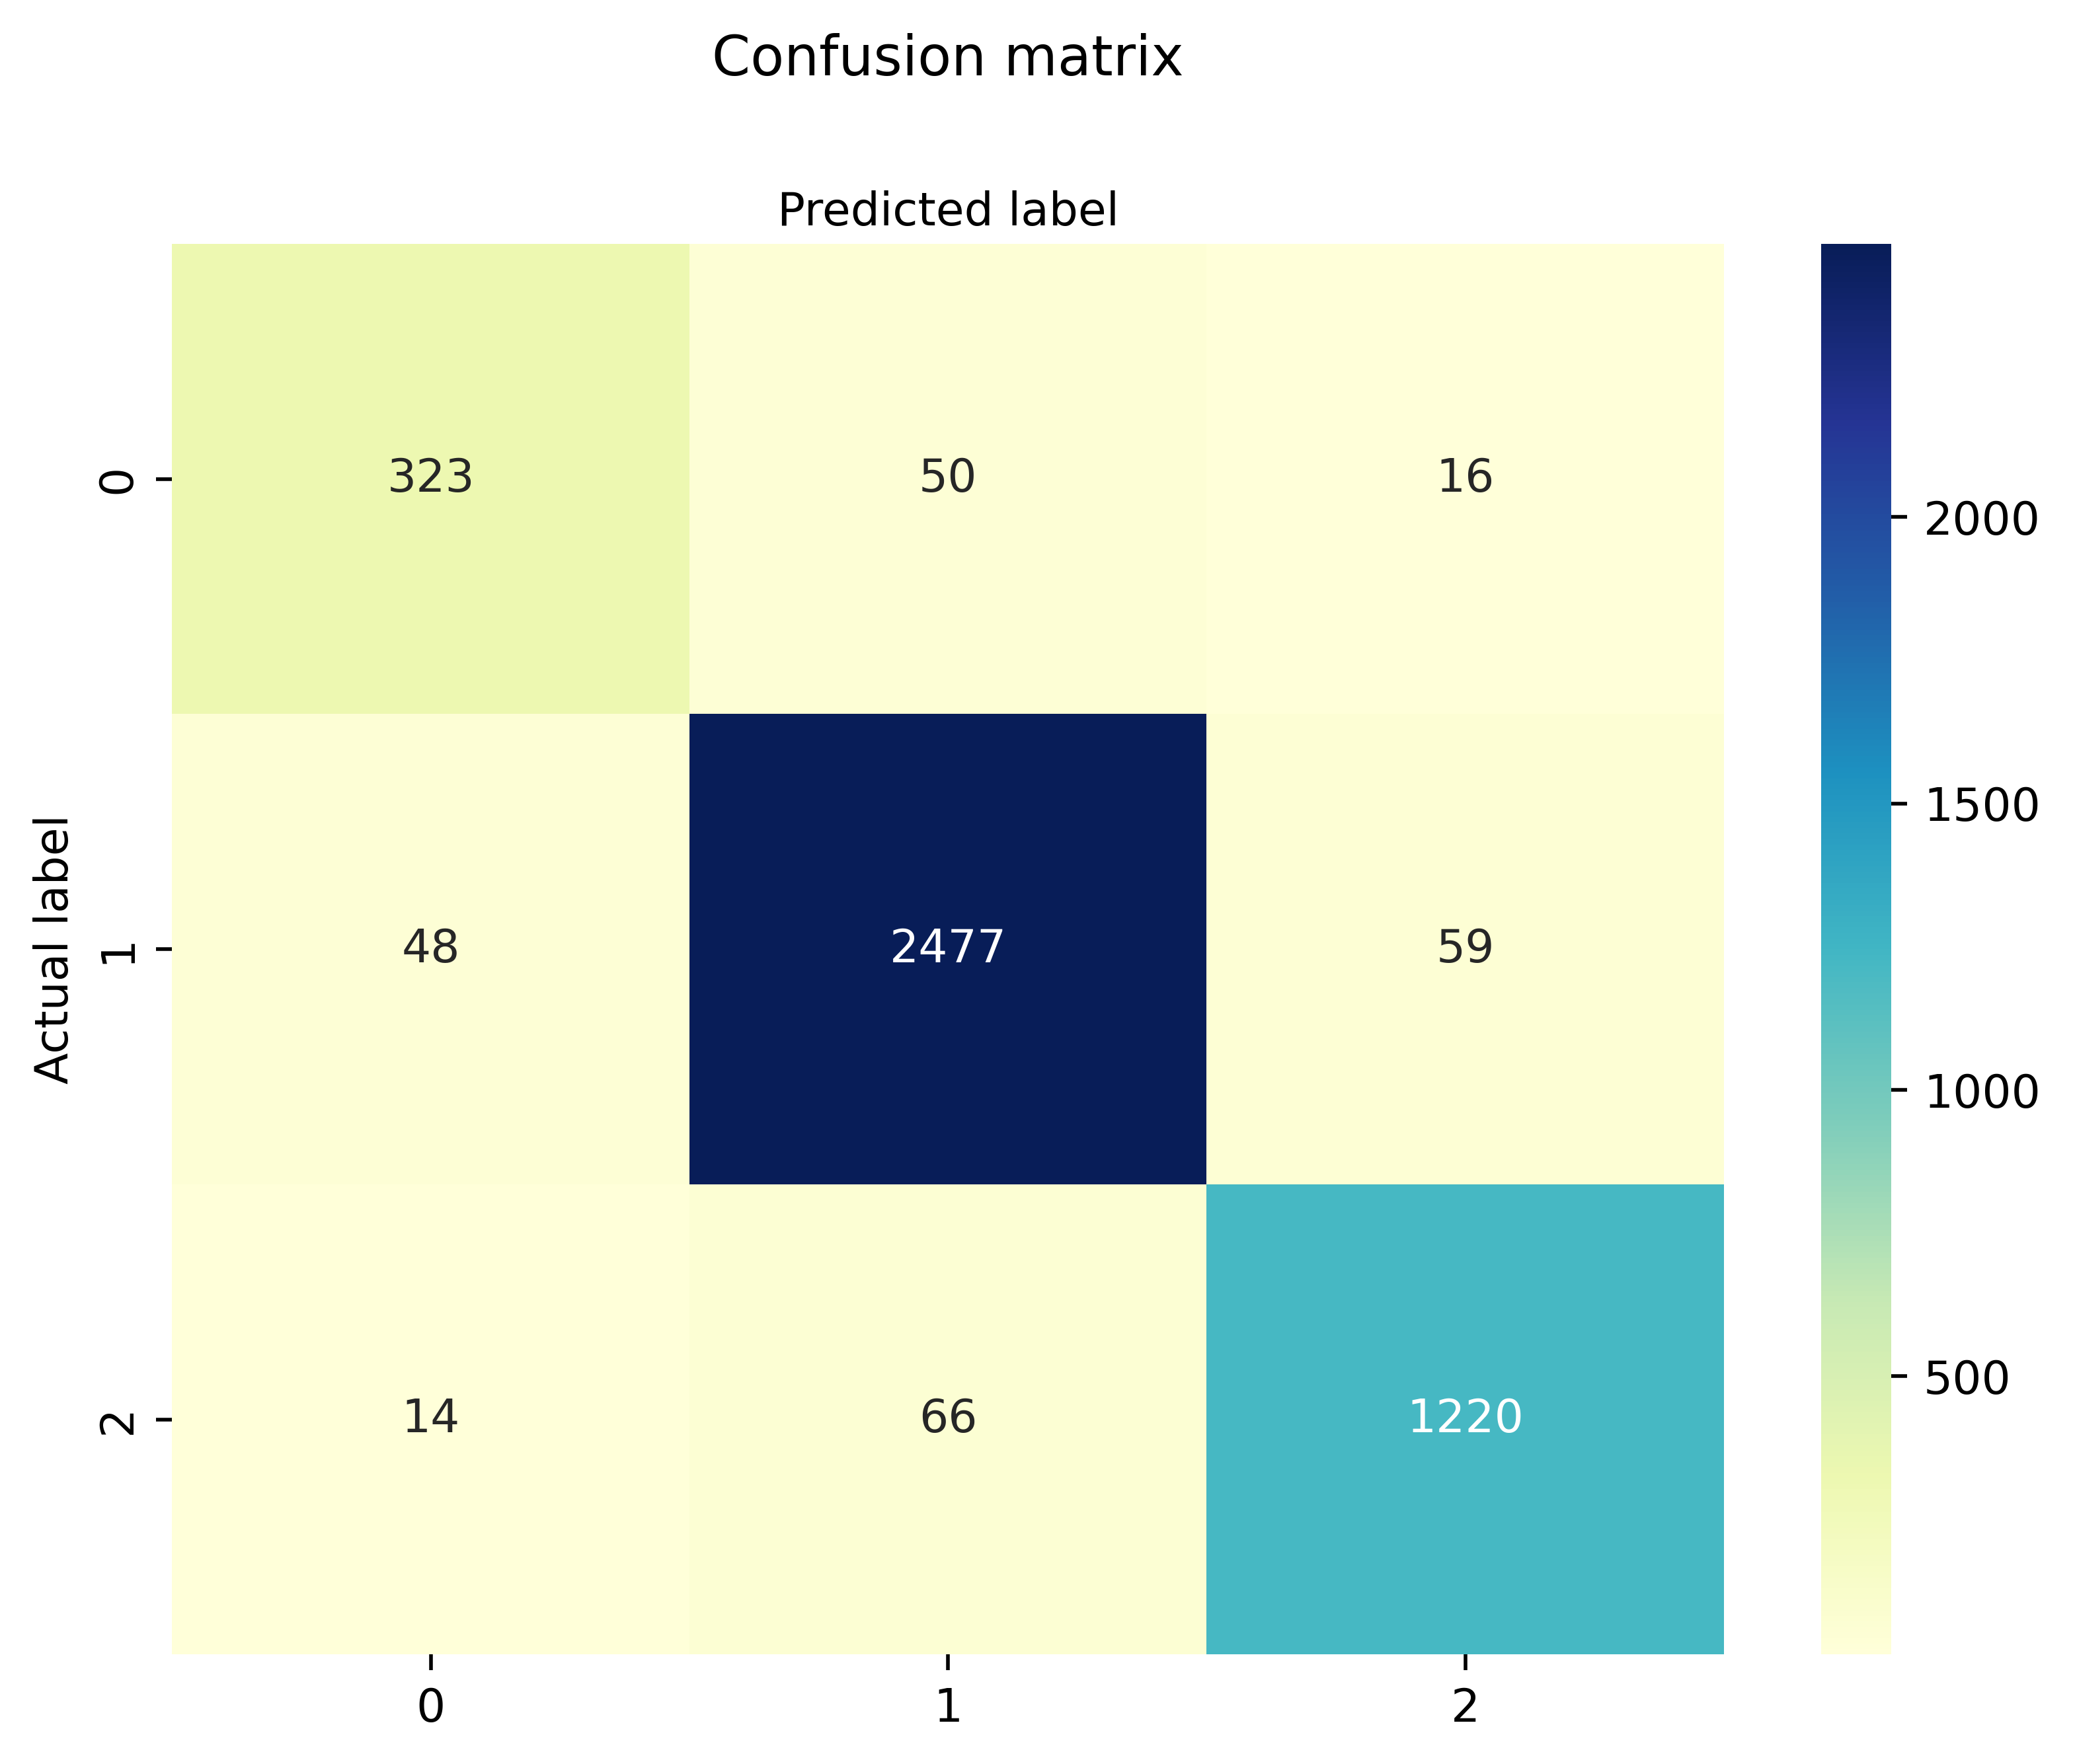

In [27]:
# plotting confusion matrix
plot_conf_mat(cm_bow)

## **Repeated K-Fold Cross Validation**

In [6]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_company = tfidf_vectorizer_company.fit_transform(X['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url, X_tfidf_company])

In [7]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

bow_vectorizer_company = CountVectorizer(max_features=1000)
X_bow_company = bow_vectorizer_company.fit_transform(X['company_names'])

X_bow_combined = hstack([X_bow_text, X_bow_url, X_bow_company])

In [8]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    xg =  XGBClassifier(n_estimators=3000, random_state=40, learning_rate = 0.3, max_depth = 3)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(xg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

python(20165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(20166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


>1 mean=0.94383365 se=0.001
>2 mean=0.94338895 se=0.001
>3 mean=0.94341212 se=0.001
>4 mean=0.94347068 se=0.001
>5 mean=0.94325294 se=0.001
>6 mean=0.94331840 se=0.001
>7 mean=0.94338530 se=0.001
>8 mean=0.94329494 se=0.001
>9 mean=0.94329752 se=0.001


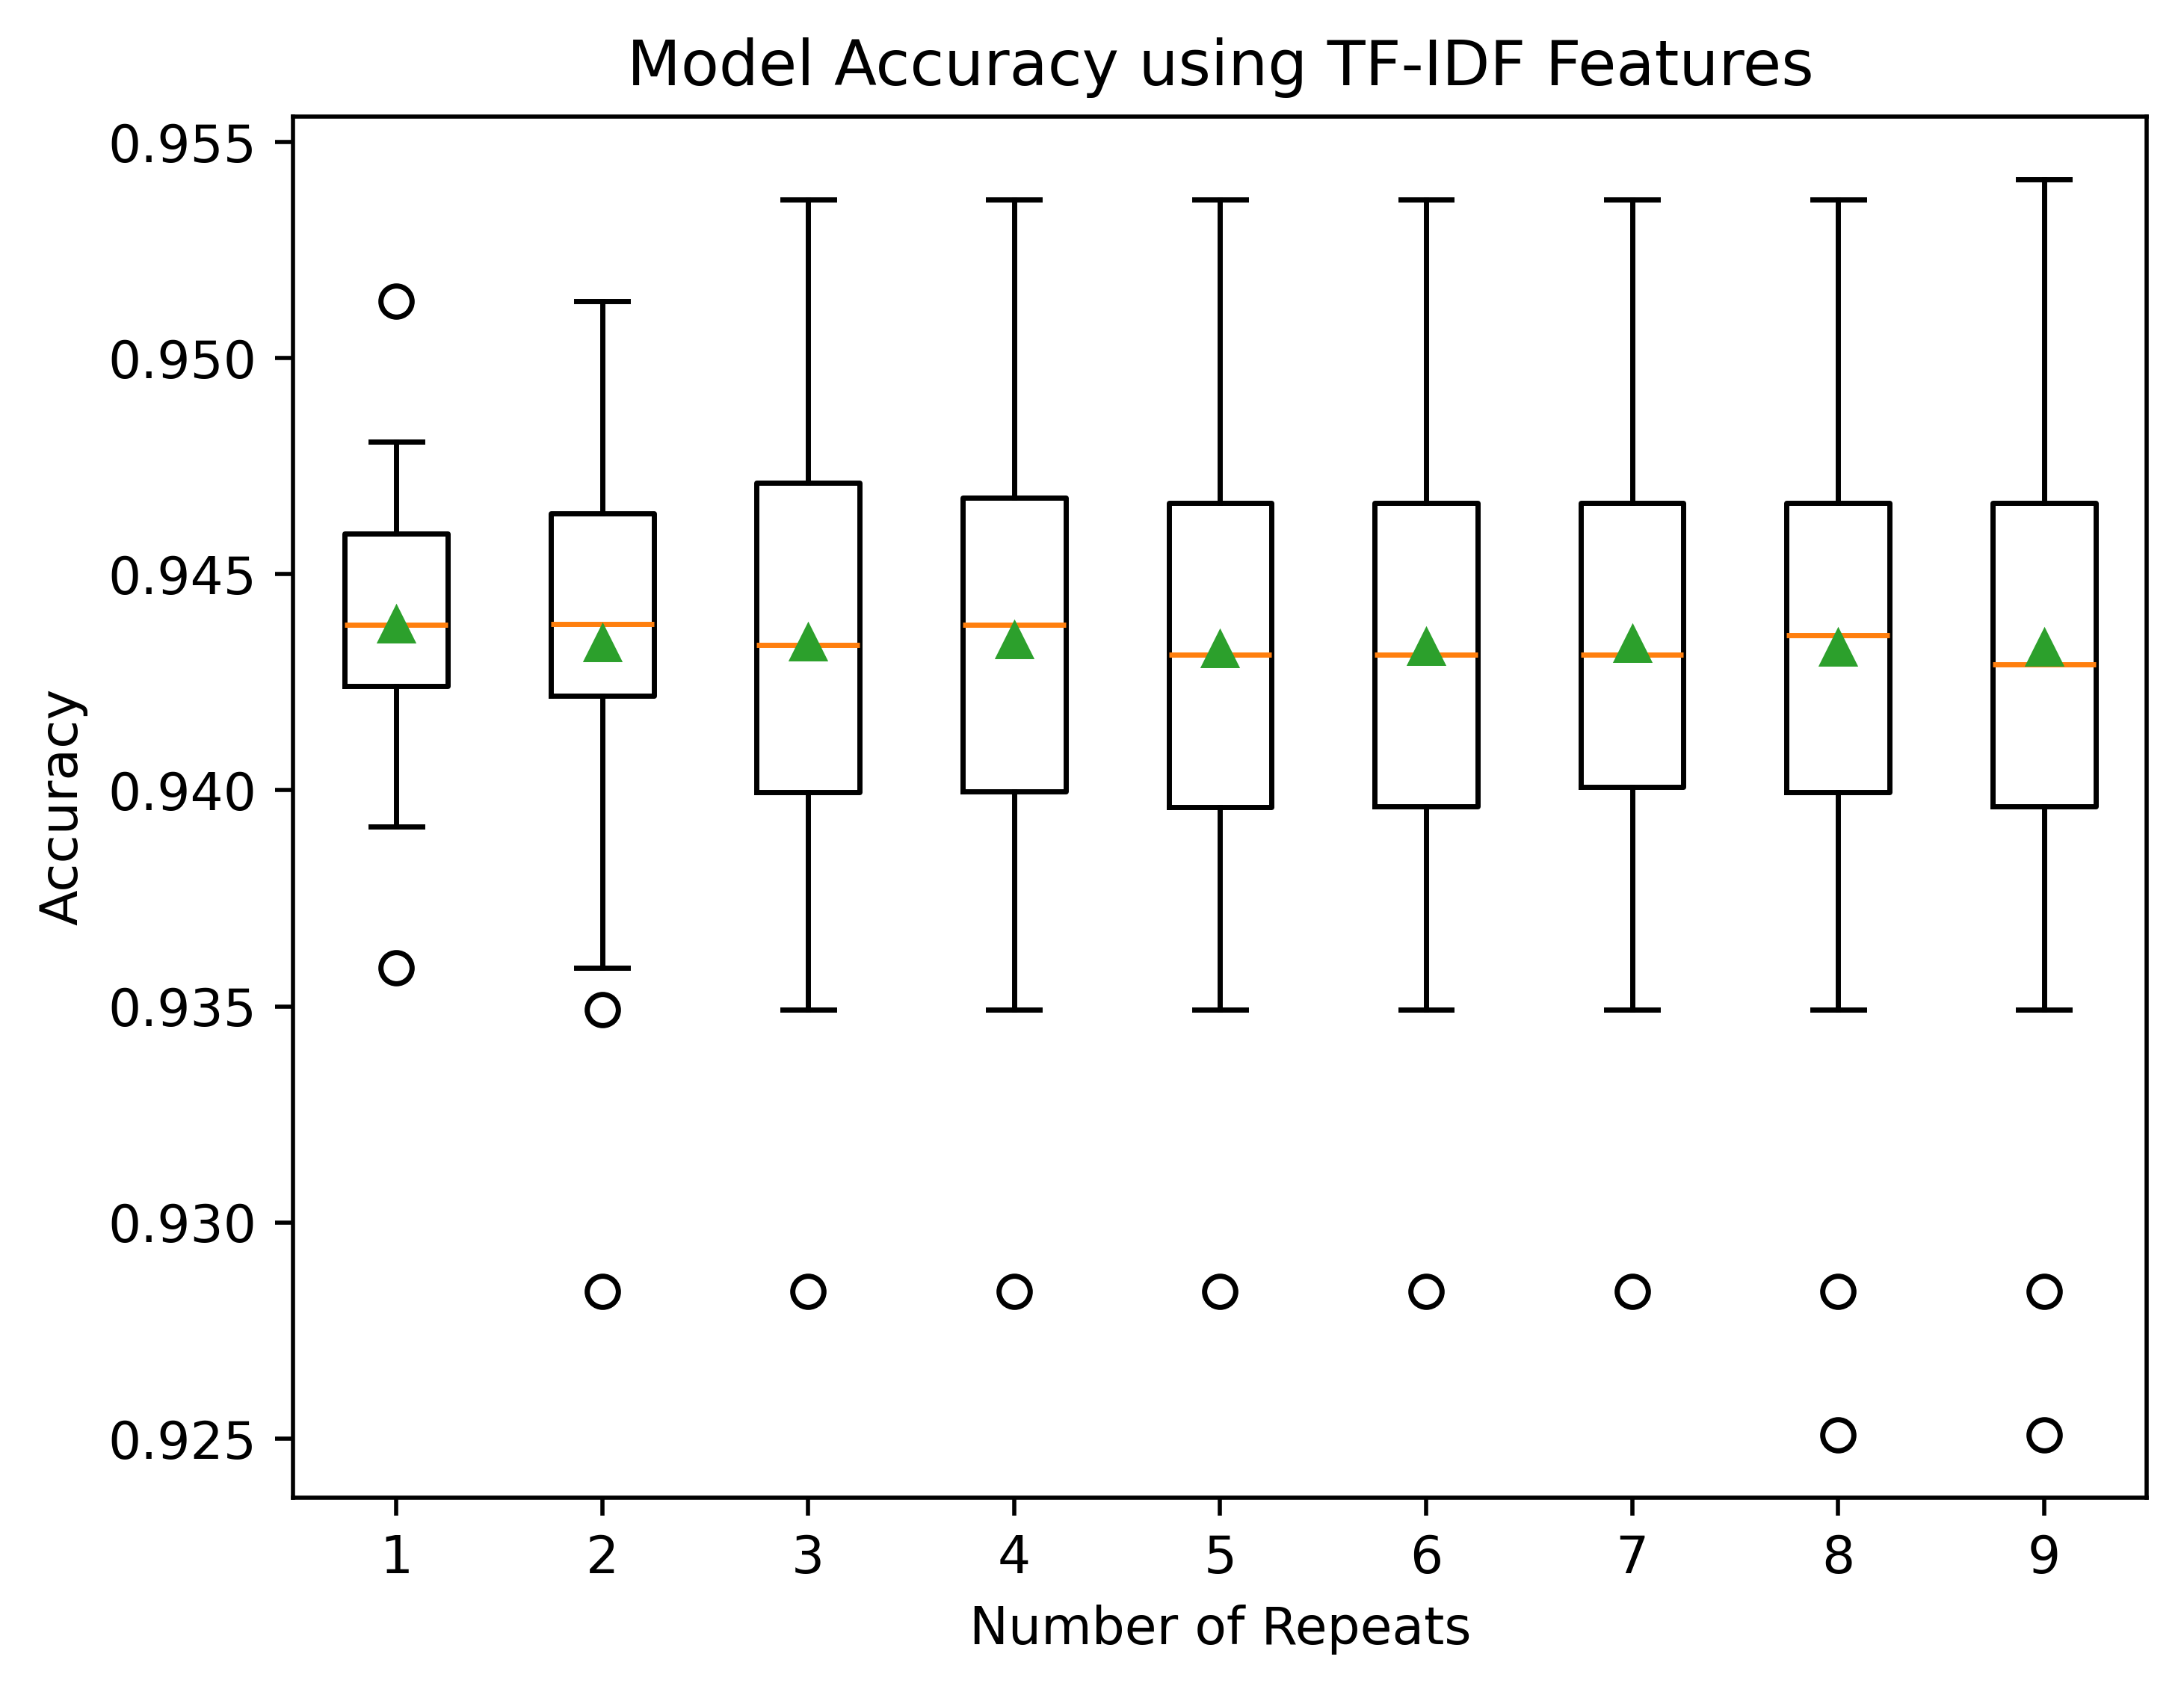

In [9]:
repeats = range(1,10)

results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_tfidf"
dataset = "1"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

>1 mean=0.94570568 se=0.001
>2 mean=0.94483992 se=0.001
>3 mean=0.94528431 se=0.001
>4 mean=0.94541307 se=0.001
>5 mean=0.94525618 se=0.001
>6 mean=0.94492537 se=0.001
>7 mean=0.94503020 se=0.001
>8 mean=0.94485713 se=0.001
>9 mean=0.94484215 se=0.001


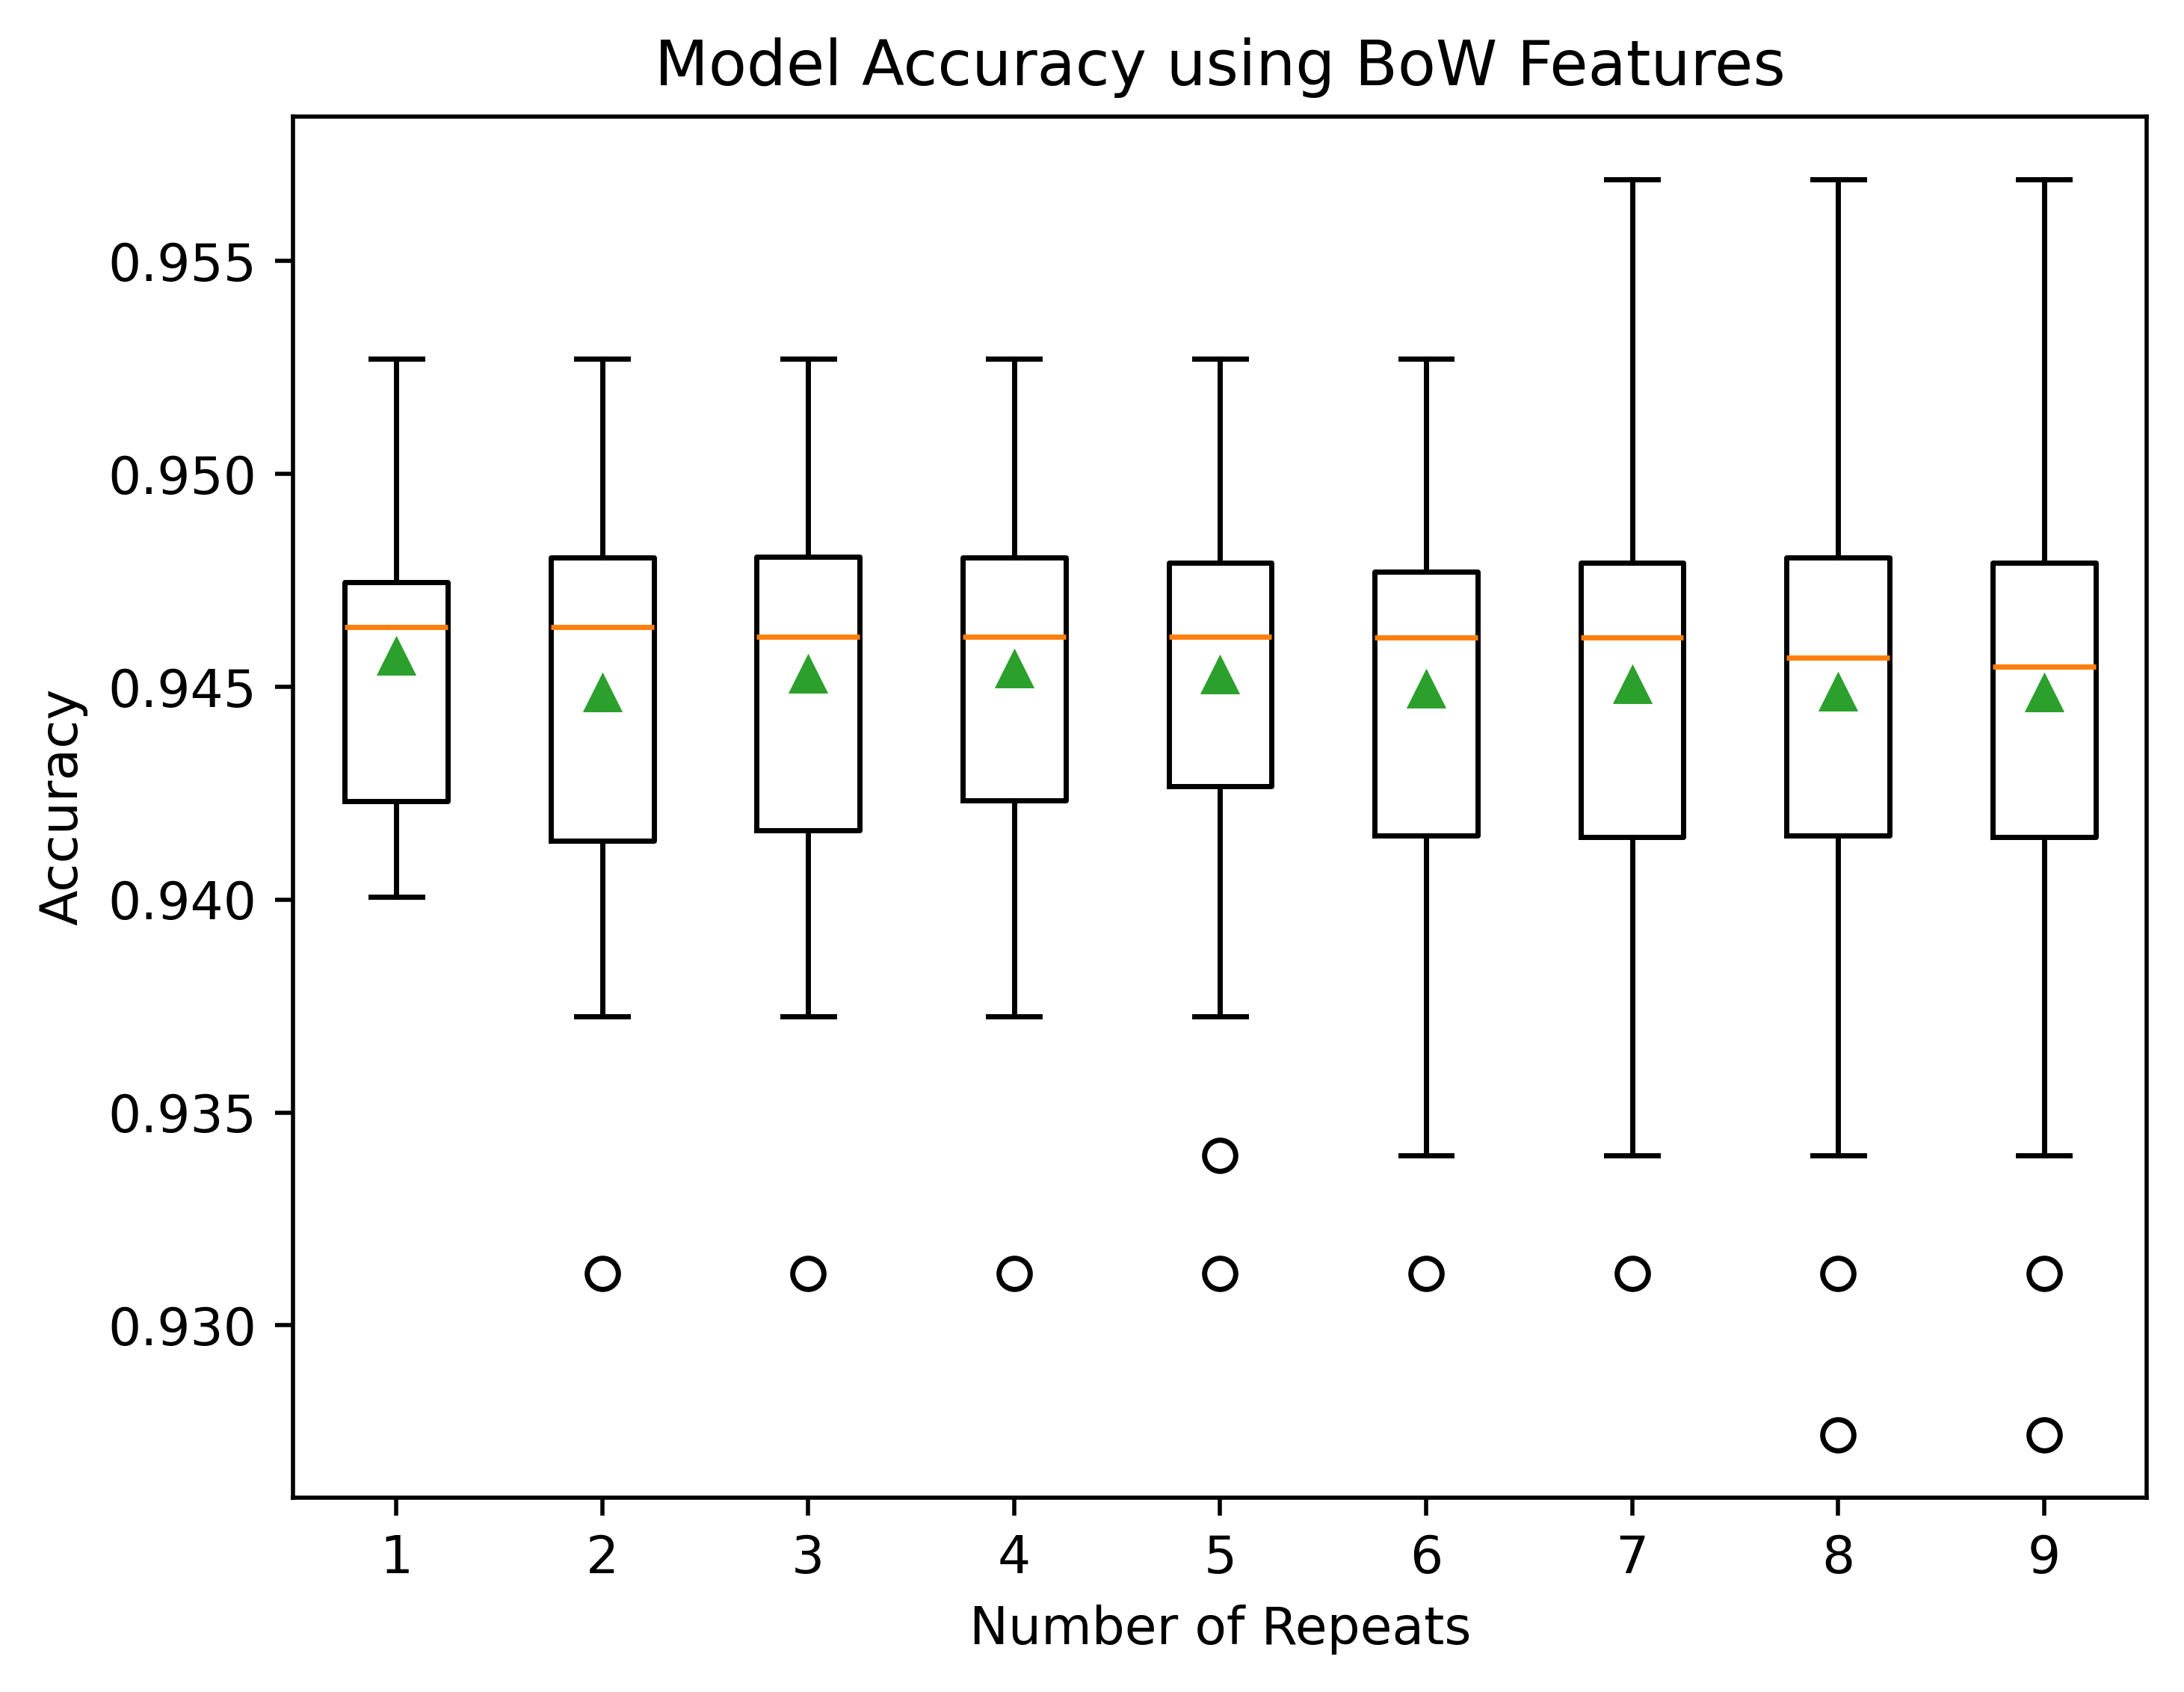

In [10]:
results = list()

for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_bow"
dataset = "1"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

## **Hyperparameter Tuning**

## Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
xgb_gd = XGBClassifier(n_estimators = 3000, random_state=40)
param_grid = {
    'learning_rate': [.2, .3, .4],
    'max_depth': [3, 5, 10],
    'gamma': [0.1,.2,.3],
    'reg_alpha': [.001, .01, .1]
}
GS = GridSearchCV(estimator=xgb_gd,param_grid=param_grid,cv=10,n_jobs=-1, verbose=True, scoring='accuracy')

In [36]:
GS.fit(X_bow_combined, y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=3000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=40, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1, 0.2, 0.3],
                         'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 10],
                         'reg_alpha': [0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=True)

In [37]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'gamma': 0.3, 'learning_rate': 0.4, 'max_depth': 5, 'reg_alpha': 0.01}

Best Score: 0.935547049575957


## RandomizedSearch CV

In [38]:
from sklearn.model_selection import RandomizedSearchCV

In [39]:
xgb_RS = XGBClassifier(n_estimators = 3000, random_state=40)
param_grid = {
    'learning_rate': [.2, .3, .4],
    'max_depth': [3, 5, 10],
    'gamma': [0.1,.2,.3],
    'reg_alpha': [.001, .01, .1]
}
RS = RandomizedSearchCV(estimator=xgb_RS,param_distributions=param_grid,cv=10,n_iter=300,n_jobs=-1, verbose=True, scoring='accuracy')

In [40]:
RS.fit(X_bow_combined, y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


/Users/josh/Desktop/Coding 👨🏽‍💻/sentiment_analysis/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=300. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=3000, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=40, ...),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'gamma': [0.1, 0.2, 0.3],
                                        'learning_rate': [0.2, 0.3, 0.4],
                                        'max_depth': [3, 5, 10],
                                        'reg_alpha': [0.001, 0.01, 0.1]},
                   scoring='accuracy', verbose=True)

In [41]:
print('Best Parameters:',RS.best_params_,end='\n\n')
print('Best Score:',RS.best_score_)

Best Parameters: {'reg_alpha': 0.01, 'max_depth': 5, 'learning_rate': 0.4, 'gamma': 0.3}

Best Score: 0.935547049575957
